In [1]:
from IPython.display import HTML, clear_output

In [2]:
# Clone Allan Online repo to notebook directory
!git clone https://github.com/nurriol2/allan-online.git
clear_output()

In [3]:
import sys
import os

# Give access to Allan Online repo files
allan_online_dir = "./allan-online"
sys.path.append(os.path.abspath(allan_online_dir))

import math
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import welch
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

# Function for calculating the overlapping Allan deviation of a time series
from allan_variance import overlapping_allan_deviation
# MATLAB or Filter Model - Shaping white noise with a filter
from noise_synthesis import simulate_flicker_noise as matlab_model

In [4]:
# Create reproducible noise density

def arw_noise(coefficient, sampling_rate, simulation_time, wn_generator):
    
    # Number of data points in the time series
    num_samples = int(simulation_time*sampling_rate)

    arw_psd = coefficient**2
    sigma_arw = math.sqrt(arw_psd*sampling_rate)
    white_noise = wn_generator.standard_normal(num_samples)
    return sigma_arw*white_noise


def rrw_noise(coefficient, sampling_rate, simulation_time, wn_generator):
    
    # Number of data points in the time series
    num_samples = int(simulation_time*sampling_rate)

    rrw_psd = coefficient**2
    sigma_arw = math.sqrt(rrw_psd*sampling_rate)
    white_noise = wn_generator.standard_normal(num_samples)
    return (1/sampling_rate)*np.cumsum(white_noise)

In [5]:
# Reproducible random numbers
wng = np.random.default_rng(0)

# Arbitrary values that made a decent looking Allan deviation (2000 sec 10Hz)
ARW_COEFFICIENT = 0.8
RRW_COEFFICIENT = 0.8

So we have the ability to create some noise density. But, we will have to wait until we actually start sweeping different parameters because right now, we don't actually have values for the required args; specifically, `sampling_rate` and `simulation_time`.

The subject under study in this experiment is the MATLAB or Filter Model of Bias Instability. So, we need a function that implements this model.
This is one of our imports above:  `matlab_model`

The function signature requires:
- Coefficient
- Sampling rate
- Simulation time
- Truncation limit

The idea is to learn how each of these parameters influences the resulting bias instability time series. We can vary each of these parameters individually across a "reasonable range" each time plotting the Power Spectral Density (PSD) and Allan deviations. With everything else kept constant, we can conclude any changes in the shapes of these plots must be a result of the changing parameter.


# Function Definitions

In [6]:
# Printing floats with many decimal places only to thousandths
fmt_long_floats = lambda x: "{:.3f}...".format(x) if (len(str(x))>4 and isinstance(x, float)) else x

In [7]:
def plot_time_series(ax, y_data, simulation_time, sampling_rate, l=""):
    
    clean_label = fmt_long_floats(l)
    
    x_data = np.arange(0, simulation_time, 1/sampling_rate)
    
    if str(clean_label)!="":
        ax.plot(x_data, y_data, label=f"{clean_label}", alpha=0.5)
    else:
        ax.plot(x_data, y_data, alpha=0.05)    

    ax.set_title(f"Combined Noise Time Series")
    ax.set_xlabel("Time (seconds)")
    ax.set_ylabel("Noise Amplitude")
    ax.grid(b=True)
    ax.legend(loc="lower right")

    return 

In [8]:
def plot_allan_deviation(ax, y_data, simulation_time, sampling_rate, l=""):

    clean_label = fmt_long_floats(l)

    tau, allan = overlapping_allan_deviation(y_data, sampling_rate)
    
    if str(clean_label)!="":
        ax.loglog(tau, allan, label=f"{clean_label}")
    else:
        ax.loglog(tau, allan)
    
    ax.set_title(f"Allan Deviation")
    ax.set_xlabel("Averaging Time (seconds)")
    ax.set_ylabel("Allan Deviation")
    ax.grid(b=True)
    ax.legend(loc="lower left")

    return 

In [9]:
def plot_power_spectral_density(ax, y_data, l=""):
    
    clean_label = fmt_long_floats(l)

    fxx, psd = welch(y_data)
    
    if str(clean_label)!="":
        ax.loglog(fxx, psd, label=clean_label)
    else:
        ax.loglog(fxx, psd)
    
    ax.set_title(f"Power Spectral Density")
    
    ax.set_xlabel("Frequency (Hertz)")
    ax.set_ylabel("PSD")
    ax.grid(b=True)
    ax.legend(loc="lower left")

    return 

In [10]:
# A function that handles plotting all 3 plots into a single figure

def make_all_plots(combined_noise, bias_instability, axes, labels, simulation_time, sampling_rate, include):
    if include:

        if axes["psd"]:
            # Plot the power spectral density of only bias instability
            plot_power_spectral_density(axes["psd"],
                                        bias_instability,
                                        labels["psd"])

        if axes["allan"]:    
            # Plot the Allan deviation of combined noise
            plot_allan_deviation(axes["allan"],
                                combined_noise,
                                simulation_time,
                                sampling_rate,
                                labels["allan"])
            
        if axes["time series"]:
            # Plot a time series of the combined noise
            plot_time_series(axes["time series"],
                            combined_noise,
                            simulation_time,
                            sampling_rate,
                            labels["time series"])
        
    else:
        
        if axes["psd"]:
            # Plot the power spectral density of only bias instability
            plot_power_spectral_density(axes["psd"],
                                        bias_instability)
            
        if axes["allan"]:
            # Plot the Allan deviation of combined noise
            plot_allan_deviation(axes["allan"],
                                combined_noise,
                                simulation_time,
                                sampling_rate)

        if axes["time series"]:    
            # Plot a time series of the combined noise
            plot_time_series(axes["time series"],
                            combined_noise,
                            simulation_time,
                            sampling_rate)

    return 

In [11]:
def line_from_arrays(x_array, y_array, line_name):
    line = go.Scatter(x=x_array,
                      y=y_array,
                      name=line_name,
                      mode="lines")
    return line

In [12]:
# Use Plotly Express to plot an Allan deviation from data

def plotly_express_allan_deviation(plot_figure, traces_to_add):
    for trace in traces_to_add:
        plot_figure.add_trace(trace)
    plot_figure.update_xaxes(type="log")
    plot_figure.update_yaxes(type="log")
    return HTML(plot_figure.to_html())

# One Shot Sampling Rate

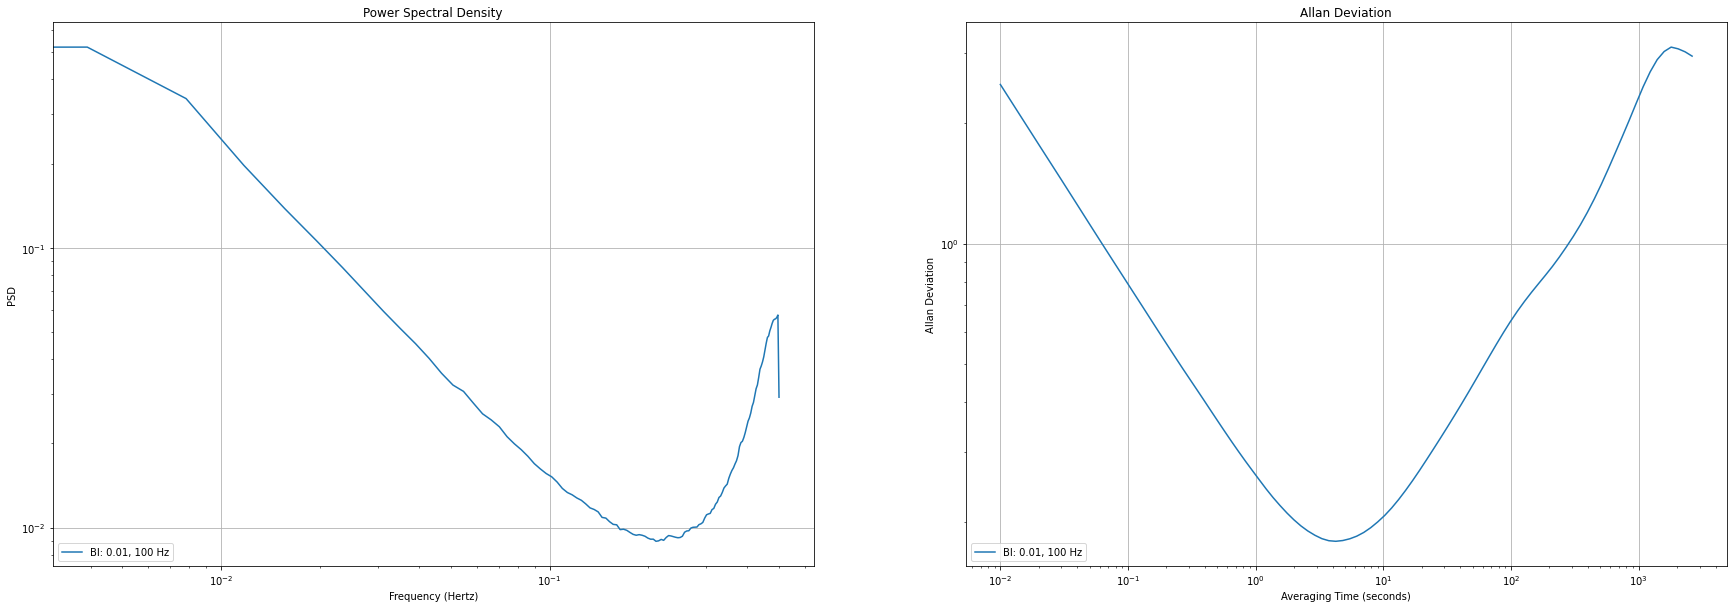

In [ ]:
# Arbitrary, but realistic choices for some parameters
SIMULATION_TIME = 10_000 #seconds
TRUNCATION = 5000 #number of filter coefficients
COEFFICIENT = 0.01
SAMPLING_RATE = 100

plt.rcParams["figure.figsize"] = (30, 10)
_, (psd_ax, al_ax) = plt.subplots(1, 2)

# Map axes object to the type of plot
axes = {"psd":psd_ax,
        "allan":al_ax,
        "time series":False}

# Map labels to the type of plot
labels = {"psd":"BI: {}, {} Hz".format(COEFFICIENT, SAMPLING_RATE),
          "allan":"BI: {}, {} Hz".format(COEFFICIENT, SAMPLING_RATE)}

# Initialize the same noise density for all runs
arw = arw_noise(ARW_COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, wng)
rrw = rrw_noise(RRW_COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, wng)

# Initialize the bias instabilty series using the current candidate parameter
bias_instability = matlab_model(COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, TRUNCATION)

# Additive noise model
combined_noise = arw + rrw + bias_instability

plot_power_spectral_density(axes["psd"], bias_instability, l=labels["psd"])
plot_allan_deviation(axes["allan"], combined_noise, SIMULATION_TIME, SAMPLING_RATE, l=labels["allan"])

# Vary the Sampling Rate

## Procedure
1. Initialize `combined_noise` noise amplitude series (ARW + RRW + FN) at `MAX_SAMPLING_RATE` Hz sampling rate
2. Derive `candidate_series` by sampling every `div` data point in `combined_noise`⁄
3. Calculate the Allan deviation of each `candidate_series`
4. Superimpose each Allan deviation from **3** onto a single figure

In [ ]:
# Arbitrary, but realistic choices for some parameters
SIMULATION_TIME = 10_000 #seconds
TRUNCATION = 5000 #number of filter coefficients
COEFFICIENT = 0.02
MAX_SAMPLING_RATE = 2000

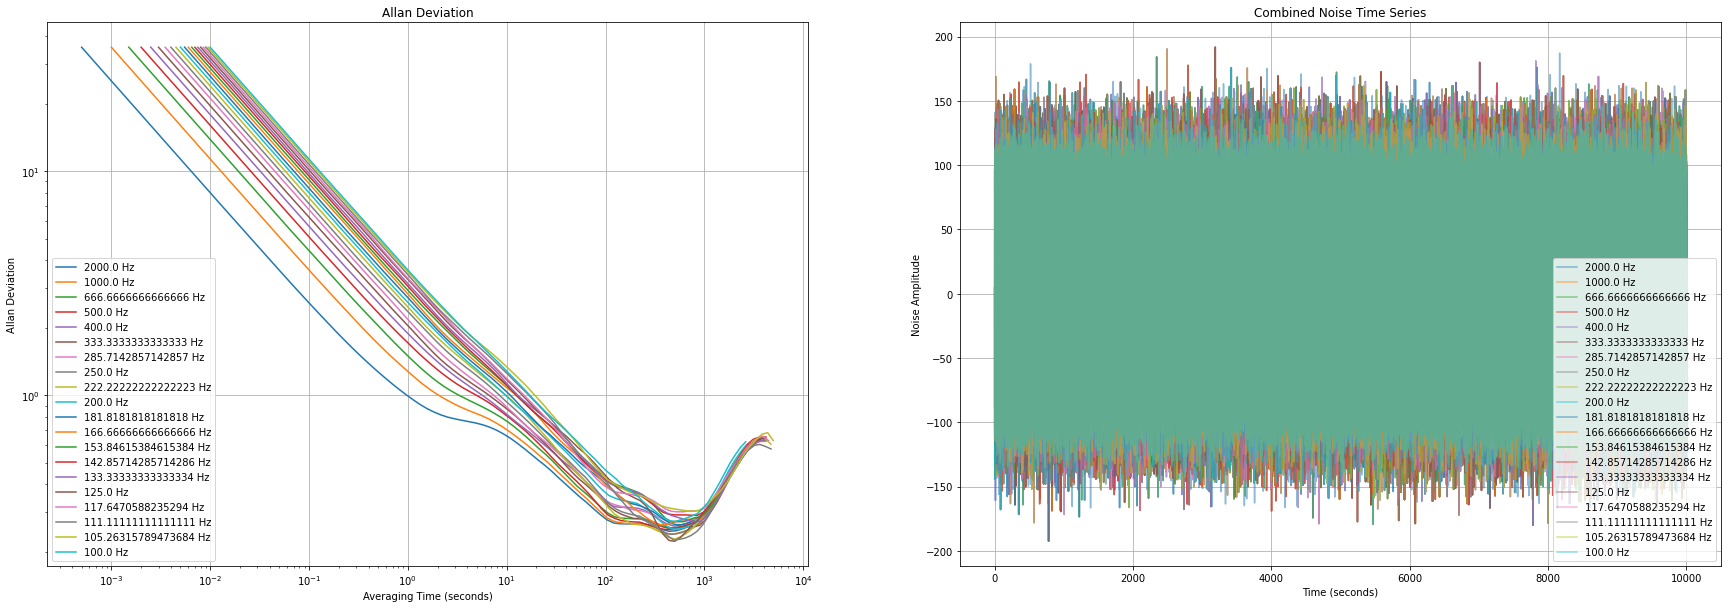

In [ ]:
# Using `make_all_plots` method
#%%time

plt.rcParams["figure.figsize"] = (30, 10)
_, (al_ax, ts_ax) = plt.subplots(1, 2)

# Map axes object to the type of plot
axes = {"allan":al_ax,
        "time series":ts_ax}


# Initialize the same noise density for all runs
arw = arw_noise(ARW_COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, wng)
rrw = rrw_noise(RRW_COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, wng)

# Initialize the bias instabilty series using the current candidate parameter
bias_instability = matlab_model(COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, TRUNCATION)

# Additive noise model
combined_noise = arw + rrw + bias_instability

for div in range(1, 21):
    candidate_series = combined_noise[0::div]
    candidate_rate = MAX_SAMPLING_RATE/div
    plot_allan_deviation(axes["allan"], candidate_series, SIMULATION_TIME, candidate_rate, l=f"{candidate_rate} Hz")
    plot_time_series(axes["time series"], candidate_series, SIMULATION_TIME, candidate_rate, l=f"{candidate_rate} Hz")
    

# Vary the Value of the Bias Instability Constant

In [ ]:
# Arbitrary, but realistic choices for some parameters
SIMULATION_TIME = 10_000 #seconds
SAMPLING_RATE = 1000 #Hz
TRUNCATION = 5000 #number of filter coefficients

In [ ]:
# Vary the BI coefficient values
candidate_coefficients = np.linspace(0.005, 1, 250)
# Only select every 3 values of candidate coefficients 
# Since the difference between choosing ex. 0.005 and 0.006 is negligable
mask = [i for i in range(0, len(candidate_coefficients), 3)]
candidate_coefficients = candidate_coefficients[mask][:8]
# Visual check for which coefficients are being used
candidate_coefficients

array([0.005     , 0.01698795, 0.0289759 , 0.04096386, 0.05295181,
       0.06493976, 0.07692771, 0.08891566, 0.10090361, 0.11289157,
       0.12487952, 0.13686747, 0.14885542, 0.16084337, 0.17283133,
       0.18481928, 0.19680723, 0.20879518, 0.22078313, 0.23277108,
       0.24475904, 0.25674699, 0.26873494, 0.28072289, 0.29271084,
       0.3046988 , 0.31668675, 0.3286747 , 0.34066265, 0.3526506 ,
       0.36463855, 0.37662651, 0.38861446, 0.40060241, 0.41259036,
       0.42457831, 0.43656627, 0.44855422, 0.46054217, 0.47253012,
       0.48451807, 0.49650602, 0.50849398, 0.52048193, 0.53246988,
       0.54445783, 0.55644578, 0.56843373, 0.58042169, 0.59240964,
       0.60439759, 0.61638554, 0.62837349, 0.64036145, 0.6523494 ,
       0.66433735, 0.6763253 , 0.68831325, 0.7003012 , 0.71228916,
       0.72427711, 0.73626506, 0.74825301, 0.76024096, 0.77222892,
       0.78421687, 0.79620482, 0.80819277, 0.82018072, 0.83216867,
       0.84415663, 0.85614458, 0.86813253, 0.88012048, 0.89210

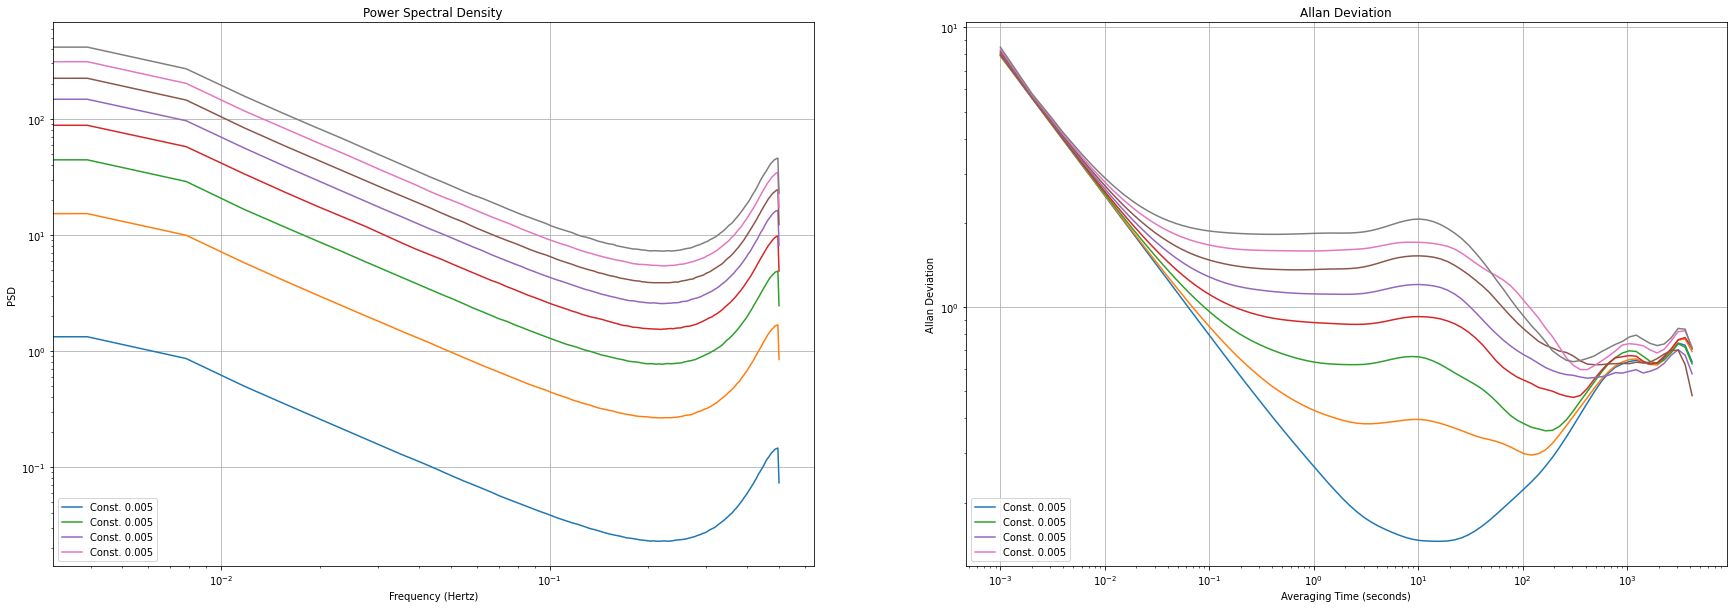

In [ ]:
# Using `make_all_plots` method
#%%time

plt.rcParams["figure.figsize"] = (30, 10)
_, (psd_ax, al_ax) = plt.subplots(1, 2)

# Initialize the same noise density for all runs
arw = arw_noise(ARW_COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, wng)
rrw = rrw_noise(RRW_COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, wng)

# Map axes object to the type of plot
axes = {"psd":psd_ax,
        "allan":al_ax,
        "time series":False}

# Map labels to the type of plot
labels = {"psd":"Const. {}",
          "allan":"Const. {}"}

# Initialize the bias instabilty series using the current candidate parameter
for run, b_coeff in enumerate(candidate_coefficients):
    bias_instability = matlab_model(b_coeff, SAMPLING_RATE, SIMULATION_TIME, TRUNCATION)

    # Additive noise model
    combined_noise = arw + rrw + bias_instability

    plot_allan_deviation(axes["allan"], combined_noise, SIMULATION_TIME, SAMPLING_RATE, l=f"Const.={b_coeff}")
    plot_power_spectral_density(axes["psd"], bias_instability, l=f"Const.={b_coeff}")

# Vary the Truncation Limit

In [ ]:
# Arbitrary, but realistic choices for some parameters
COEFFICIENT = 0.02
SIMULATION_TIME = 10_000 #seconds
SAMPLING_RATE = 1000 #Hz

In [ ]:
# Vary the truncation limit (number of coefficients in the IIR filter)
candidate_truncation = np.arange(100, 10_000, 100)
# Only select a subset of candidates
mask = [i for i in range(0, len(candidate_truncation), 10)]
candidate_truncation = candidate_truncation[mask]
# Visual check for which truncation limits will be used
candidate_truncation

array([ 100, 1100, 2100, 3100, 4100, 5100, 6100, 7100, 8100, 9100])

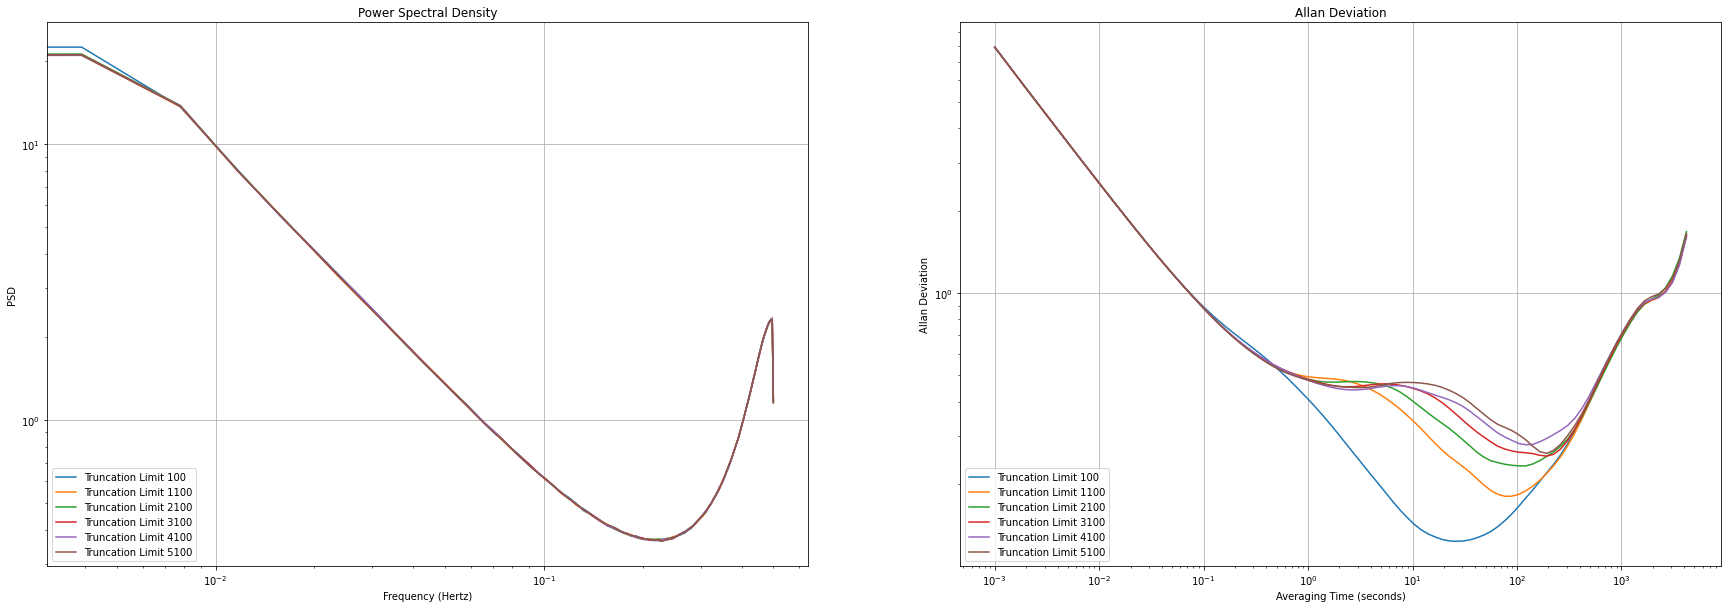

In [ ]:
# Using `make_all_plots` method
#%%time

plt.rcParams["figure.figsize"] = (30, 10)
_, (psd_ax, al_ax) = plt.subplots(1, 2)

# Initialize the same noise density for all runs
arw = arw_noise(ARW_COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, wng)
rrw = rrw_noise(RRW_COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, wng)

# Map axes object to the type of plot
axes = {"psd":psd_ax,
        "allan":al_ax}

# Map labels to the type of plot
labels = {"psd":"Truncation: {}",
          "allan":"Truncation: {}"}

# Initialize the bias instabilty series using the current candidate parameter
for run, trunc in enumerate(candidate_truncation[:6]):
    bias_instability = matlab_model(COEFFICIENT, SAMPLING_RATE, SIMULATION_TIME, trunc)

    # Additive noise model
    combined_noise = arw + rrw + bias_instability


    plot_allan_deviation(al_ax, combined_noise, SIMULATION_TIME, SAMPLING_RATE, "Truncation Limit {}".format(trunc))
    plot_power_spectral_density(psd_ax, bias_instability, "Truncation Limit {}".format(trunc))

    #make_all_plots(combined_noise, bias_instability, axes, labels, SIMULATION_TIME, SAMPLING_RATE, include=True)

# Sampling Rate and Coefficient

In [ ]:
# Arbitrary, but realistic choices for some parameters
SIMULATION_TIME = 10_000 #seconds
TRUNCATION = 5000

In [ ]:
candidate_coefficients = [0.005, 0.02, 0.5]
candidate_sampling_rates = [100, 500, 1000]
#candidate_sampling_rates = [1, 10, 100]

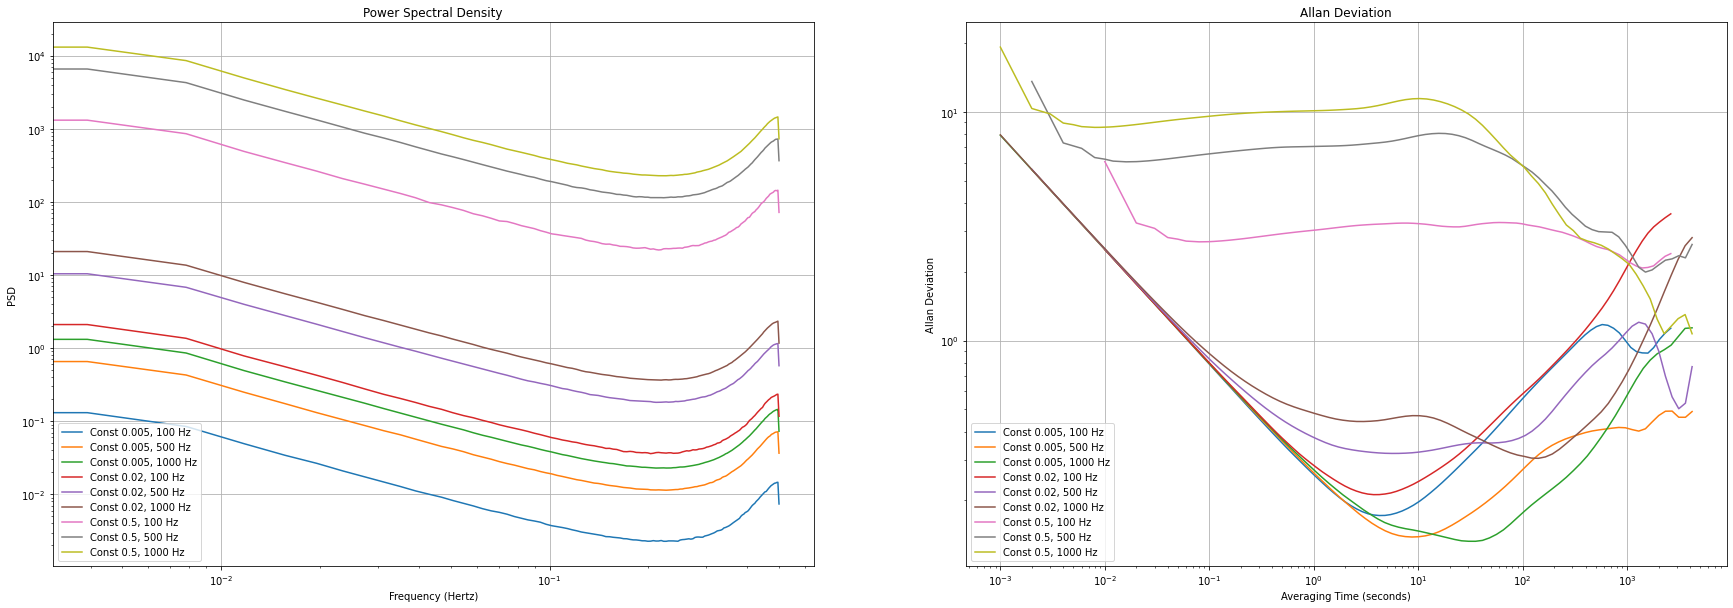

In [ ]:
plt.rcParams["figure.figsize"] = (30, 10)
_, (psd_ax, al_ax) = plt.subplots(1, 2)

# Map axes object to the type of plot
axes = {"psd":psd_ax,
        "allan":al_ax,
        "time series":False}

for coeff in candidate_coefficients:
    for rate in candidate_sampling_rates:
        arw = arw_noise(ARW_COEFFICIENT, rate, SIMULATION_TIME, wng)
        rrw = rrw_noise(ARW_COEFFICIENT, rate, SIMULATION_TIME, wng)
        bias_instability = matlab_model(coeff, rate, SIMULATION_TIME, TRUNCATION)
        combined = arw + rrw + bias_instability

        plot_allan_deviation(al_ax, combined, SIMULATION_TIME, rate, "Const {}, {} Hz".format(coeff, rate))
        plot_power_spectral_density(psd_ax, bias_instability, "Const {}, {} Hz".format(coeff, rate))

# Vary Sampling Rate and Bias Instability Coefficient
## Undersampling Method

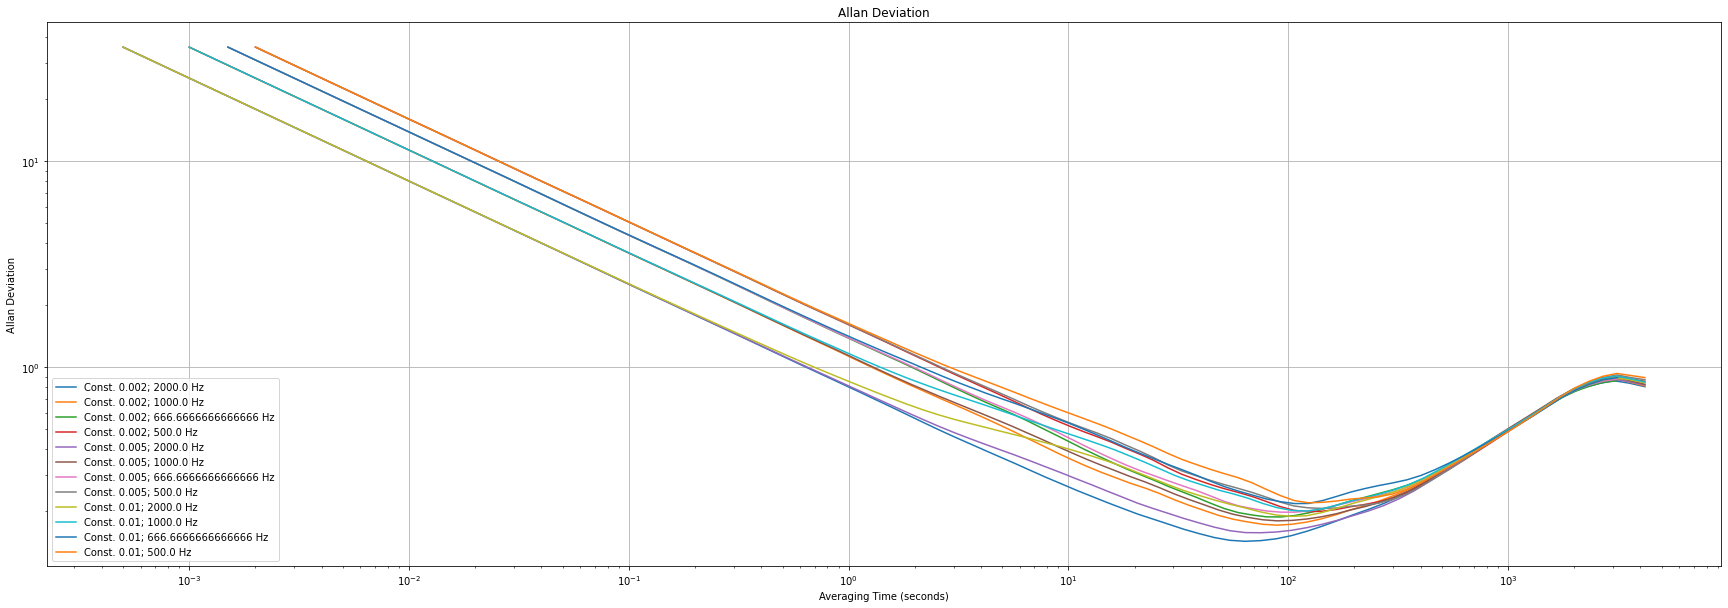

In [ ]:
# Arbitrary, but realistic choices for some parameters
SIMULATION_TIME = 10_000 #seconds
TRUNCATION = 5000
MAX_SAMPLING_RATE = 2000
candidate_coefficients = [0.002, 0.005, 0.01]

# Using `make_all_plots` method
#%%time

plt.rcParams["figure.figsize"] = (30, 10)
_, al_ax = plt.subplots(1, 1)


# Initialize the same noise density for all runs
arw = arw_noise(ARW_COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, wng)
rrw = rrw_noise(RRW_COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, wng)


for coeff in candidate_coefficients:

    # Initialize the bias instabilty series using the current candidate parameter
    bias_instability = matlab_model(coeff, MAX_SAMPLING_RATE, SIMULATION_TIME, TRUNCATION)

    # Additive noise model
    combined_noise = arw + rrw + bias_instability

    for div in range(1, 5):
        # Undersample the exact same data points initially created
        candidate_series = combined_noise[0::div]
        candidate_rate = MAX_SAMPLING_RATE/div
        plot_allan_deviation(al_ax, candidate_series, SIMULATION_TIME, candidate_rate, l=f"Const. {coeff}; {candidate_rate} Hz")
    

In [13]:
# Arbitrary, but realistic choices for some parameters
SIMULATION_TIME = 10_000 #seconds
TRUNCATION = 5000
MAX_SAMPLING_RATE = 2000
candidate_coefficients = [0.002, 0.005, 0.01]

# Initialize the same noise density for all runs
arw = arw_noise(ARW_COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, wng)
rrw = rrw_noise(RRW_COEFFICIENT, MAX_SAMPLING_RATE, SIMULATION_TIME, wng)

traces_to_add = []

for coeff in candidate_coefficients:

    # Initialize the bias instabilty series using the current candidate parameter
    bias_instability = matlab_model(coeff, MAX_SAMPLING_RATE, SIMULATION_TIME, TRUNCATION)

    combined_noise = arw + rrw + bias_instability

    for div in range(1, 6):

        current_series = combined_noise[0::div]
        current_sampling_rate = MAX_SAMPLING_RATE/div
        
        tau_array, allan_array = overlapping_allan_deviation(current_series, current_sampling_rate)
        
        trace = line_from_arrays(tau_array, allan_array, "Const. {}, {} Hz".format(coeff, fmt_long_floats(current_sampling_rate)))
        
        traces_to_add.append(trace)

# Figure to render plot
allan_deviation_figure = go.Figure()

plotly_express_allan_deviation(allan_deviation_figure, traces_to_add)